"""
Created on Fri Sep 22 12:26:33 2017

@author: Manikanda Krishnan V (06-02-02-10-22-17-1-14787)
"""


In [1]:
def padImage(im,filter_shape,padding_type="zero") :
    im_size = im.shape 
    padding_thickness = [x/2 for x in filter_shape]
    lower_corner = (padding_thickness[0]+im_size[0],padding_thickness[1]+im_size[1])
    im_col_flipped = im[:,-1::-1]
    im_row_flipped = im[-1::-1,:]
    im_both_flipped = im[-1::-1,-1::-1]
    zeros = np.zeros(im_size)
    if padding_type == "zero" :
            new_im = np.vstack([np.hstack([zeros,zeros,zeros]),
                                np.hstack([zeros,im,zeros]),
                                np.hstack([zeros,zeros,zeros])])

    elif padding_type == "symmetric" :
            new_im = np.vstack([np.hstack([im_both_flipped,im_row_flipped,im_both_flipped]),
                                np.hstack([im_col_flipped,im,im_col_flipped]),
                                np.hstack([im_both_flipped,im_row_flipped,im_both_flipped])])
    elif padding_type == "periodic" :
            new_im = np.vstack([np.hstack([im,im,im]),
                                np.hstack([im,im,im]),
                                np.hstack([im,im,im])])

    return new_im[im_size[0]-padding_thickness[0]:2*im_size[0]+padding_thickness[0],im_size[1]-padding_thickness[1]:2*im_size[1]+padding_thickness[1]]

In [2]:
def my_conv2D(image,filt,padding_type="zero") :
    mask = filt[-1::-1,-1::-1]
    mask_shape = mask.shape
    im = padImage(image,mask_shape,padding_type)
    new_image = np.zeros(image.shape)
    for x in range(0,image.shape[0]) :
        for y in range(0,image.shape[1]) :
            new_image[x,y] = np.sum(im[x:x+mask_shape[0],y:y+mask_shape[1]]*mask)
    return new_image            

In [3]:
def my_conv1D(row,filt,padding_type = "zero") :
    mask = filt[-1::-1]
    row.shape = (1,row.shape[0])
    new_row = np.zeros((row.shape[0],row.shape[1]- 2*(mask.shape[1]/2)))
    for y in range(0,row.shape[1] - 2*(mask.shape[1]/2)) :
        new_row[0,y] = np.sum(row[0,y:y+mask.shape[1]]*mask)
    return new_row

In [4]:
def my_conv2D_separable(image,filt_y,filt_x,padding_type="zero") :
    mask_shape = (filt_x.shape[1],filt_y.shape[1])
    im = padImage(image,mask_shape,padding_type)
    (m,n) = im.shape
    conv_y_im = np.vstack([my_conv1D(im[x,:],filt_y,padding_type) for x in range(0,m)])
    (m,n) = conv_y_im.shape
    conv_x_im = np.vstack([my_conv1D(conv_y_im[:,y],filt_x,padding_type) for y in range(0,n)])
    return conv_x_im.T

In [5]:
def non_linear_neighborhood_processing(image,mask_shape,operator,padding_type="zero") :
    """
        operator is a function that takes a neighborhood of mask_shape as input and returns a value .
    """
    im = padImage(image,mask_shape,padding_type)
    new_image = np.zeros(image.shape)
    for x in range(0,image.shape[0]) :
        for y in range(0,image.shape[1]) :
            new_image[x,y] = operator(im[x:x+mask_shape[0],y:y+mask_shape[1]])
    return new_image      

Zero Detector checks if there is a change in sign or value going to zero across all 8 directions

In [6]:
def zeroDetector(x) :
    return (x[1,1]*x[0,0] <=0) or (x[1,1]*x[0,1] <=0) or (x[1,1]*x[0,2] <=0) or (x[1,1]*x[1,2] <=0) or (x[1,1]*x[1,0] <=0) or (x[1,1]*x[2,0] <=0) or (x[1,1]*x[2,1] <=0) or (x[1,1]*x[2,2] <=0)

In [7]:
def prewitt(image) :
    derivative = np.array([-1,0,1])
    derivative.shape=(1,3)
    smoother = np.array([1,1,1])
    smoother.shape=(1,3)
    g_y = my_conv2D_separable(image,derivative,smoother,padding_type="symmetric")
    g_x = my_conv2D_separable(image,smoother,derivative,padding_type="symmetric")
    magnitude_image = np.sqrt(g_y**2+g_x**2)
    angle_image = np.arctan(g_y/(g_x+0.00001))
    return magnitude_image,angle_image

Sobel computes central difference after smoothing via a weighted smoother [1,2,1]

In [8]:
def sobel(image) :
    derivative = np.array([-1,0,1])
    derivative.shape=(1,3)
    smoother = np.array([1,2,1])
    smoother.shape=(1,3)
    g_y = my_conv2D_separable(image,derivative,smoother,padding_type="symmetric")
    g_x = my_conv2D_separable(image,smoother,derivative,padding_type="symmetric")
    magnitude_image = np.sqrt(g_y**2+g_x**2)
    angle_image = np.arctan(g_y/(g_x+0.00001))
    return magnitude_image,angle_image*180/np.pi

Convolution using the laplacian of gaussian mask , same as doing gaussian smoothing and applying the laplacian operator . Edges are detected by 0 crossings

In [9]:
def laplacian_of_gaussian(image,sigma) :
    import math
    laplacian_gaussian = np.vstack([[math.exp(-(i**2+j**2)/2/sigma**2)*(i**2+j**2-2*sigma**2)/sigma**6/np.pi for j in range(int(math.floor(-3*sigma)),int(math.ceil(3*sigma+1)))] for i in range(int(math.floor(-3*sigma)),int(math.ceil(3*sigma+1)))])
    #laplacian_gaussian = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
    return non_linear_neighborhood_processing(my_conv2D(image,laplacian_gaussian,padding_type="symmetric"),(3,3),zeroDetector,padding_type="symmetric")

LoG can be appromiated as the difference of two gaussian smoothed images

In [10]:
def difference_of_gaussian(image,sigma_1,sigma_2) :
    import math
    gaussian_1 = np.vstack([[math.exp(-(i**2+j**2)/2/sigma_1**2)/2/np.pi/sigma_1**2  for j in range(int(math.floor(-3*sigma_1)),int(math.ceil(3*sigma_1+1)))] for i in range(int(math.floor(-3*sigma_1)),int(math.ceil(3*sigma_1+1)))])
    gaussian_2 = np.vstack([[math.exp(-(i**2+j**2)/2/sigma_2**2)/2/np.pi/sigma_2**2  for j in range(int(math.floor(-3*sigma_2)),int(math.ceil(3*sigma_2+1)))] for i in range(int(math.floor(-3*sigma_2)),int(math.ceil(3*sigma_2+1)))])
    return non_linear_neighborhood_processing(my_conv2D(image,gaussian_1,padding_type="symmetric") - my_conv2D(image,gaussian_2,padding_type="symmetric"),(3,3),zeroDetector,padding_type="symmetric")

Canny differs from the other first derivative edge detectors by performing non maximal suppression , having 2 thresholds and then performing edgelinking. This process is called hysterisis thresholding

In [11]:
def canny(image) :
    mag,angle = sobel(image)
    def round_angle(angle) :
        if 0 < abs(angle) < 22.5  :
            return 0
        elif 22.5 < angle < 67.5 :
            return 45
        elif -67.5<angle<-22.5 :
            return 135
        else :
            return 90
    ro_ang = np.vectorize(round_angle)
    angle = ro_ang(angle)
    combined = np.array(map(lambda x,y : zip(x,y) ,mag,angle))
    def maximal_suppress(image) :
        angle = image[1,1,1]
        vals = []
        if angle == 0 :
            return np.argmax(image[1,:,0])==1
        elif angle == 90 :
            return np.argmax( image[:,1,0]) == 1
        elif angle == 45 :
            return np.argmax([image[0,2,0],image[1,1,0],image[2,1,0]]) == 1
        else :
            return np.argmax([image[0,0,0],image[1,1,0],image[2,2,0]]) == 1
    suppressed = non_linear_neighborhood_processing(combined,(3,3),maximal_suppress,padding_type="symmetric")
    suppressed = mag*suppressed[:,:,0]
    gnh = suppressed >= 0.1*np.max(suppressed)
    gnl = suppressed >= 0.8*np.max(suppressed)
    io.imshow(gnh)
    plt.show()
    io.imshow(gnl)
    plt.show()
    gnl = gnl & ~gnh
    def traverse(i, j):
        x = [-1, 0, 1, -1, 1, -1, 0, 1]
        y = [-1, -1, -1, 0, 0, 1, 1, 1]
        for k in range(8):
            if gnh[i+x[k]][j+y[k]]==0 and gnl[i+x[k]][j+y[k]]!=0:
                gnh[i+x[k]][j+y[k]]=1
                traverse(i+x[k], j+y[k])
    height,width = gnh.shape
    for i in range(1, width-1):
        for j in range(1, height-1):
            if gnh[i][j]:
                gnh[i][j]=1
                traverse(i, j)
    return gnh

original image


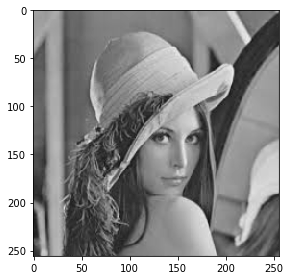

prewitt


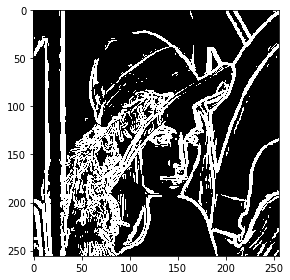

sobel


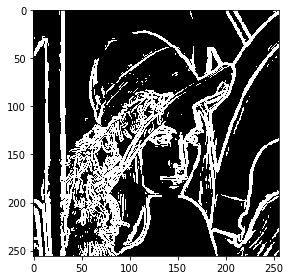

Canny


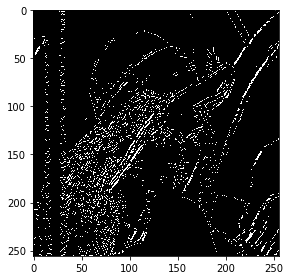

C:\Users\Sephiroth\Anaconda2\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


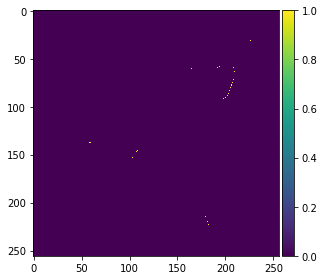

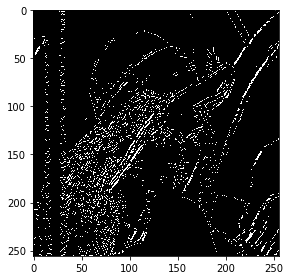

DoG


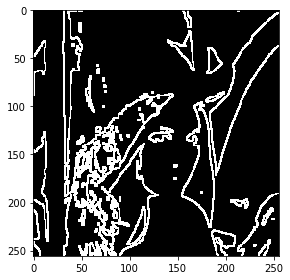

LoG


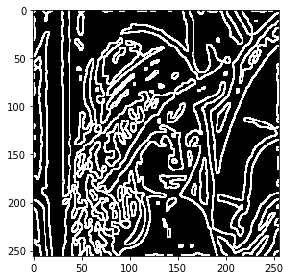

original image


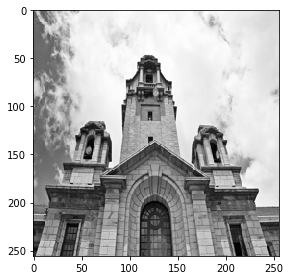

prewitt


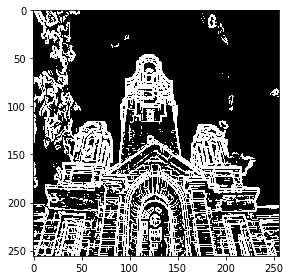

sobel


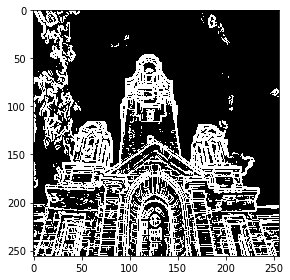

Canny


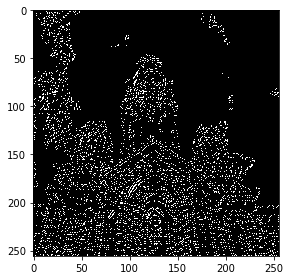

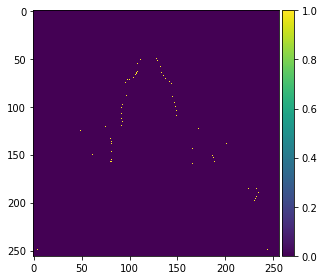

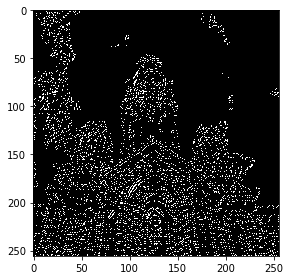

DoG


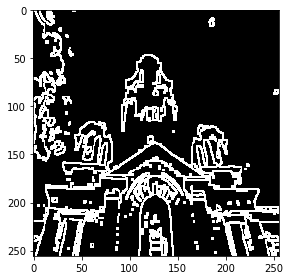

LoG


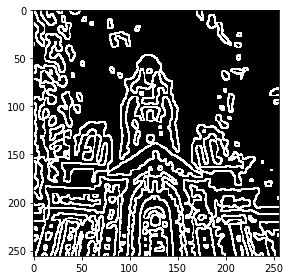

original image


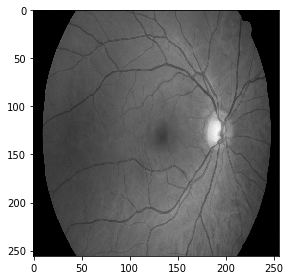

prewitt


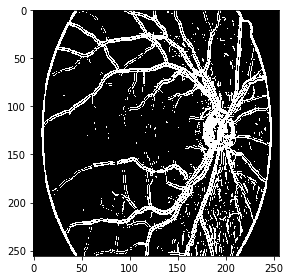

sobel


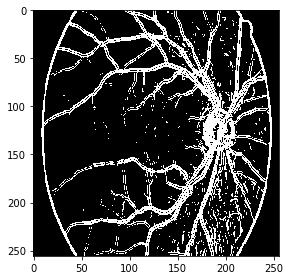

Canny


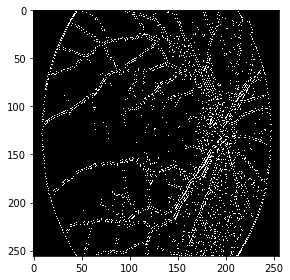

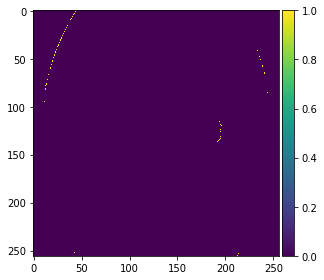

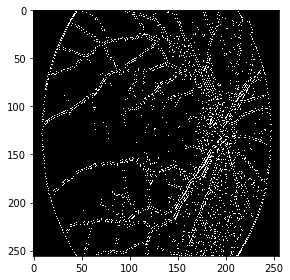

DoG


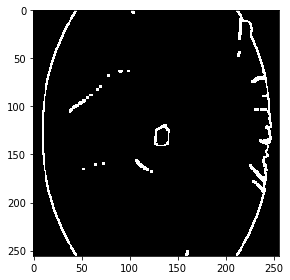

LoG


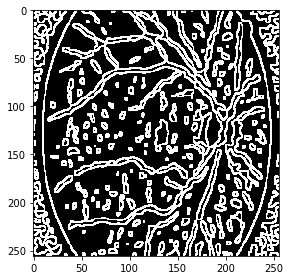

original image


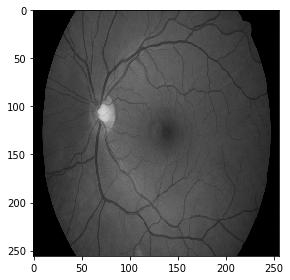

prewitt


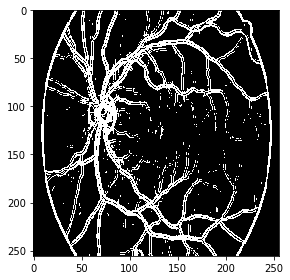

sobel


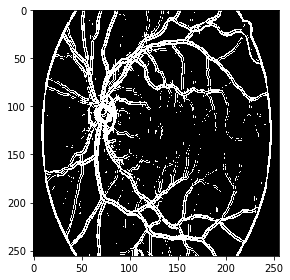

Canny


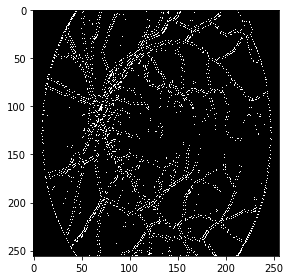

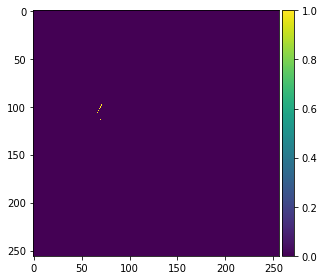

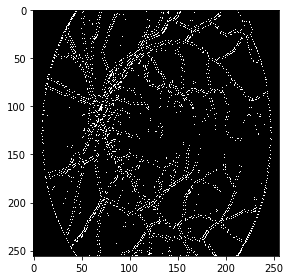

DoG


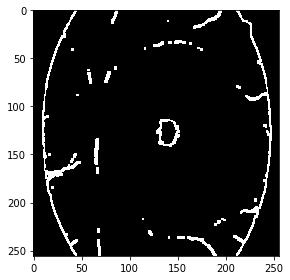

LoG


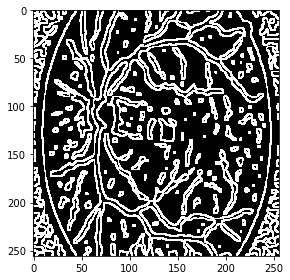

In [12]:

import numpy as np
import matplotlib.pyplot as plt
from skimage import io,color
from skimage import transform

im_path = r"C:\Users\Sephiroth\Downloads\iisc\DIP codes\{}"
images = ["lena.jpg","IISc.tiff","healthy\\01_h.jpg","healthy\\12_h.jpg"]
for image in images :
    image_path = im_path.format(image)
    print "original image"
    im = transform.resize(color.rgb2gray(io.imread(image_path)),(256,256))
    io.imshow(im)
    plt.show()
    print "prewitt"
    mag,ang = prewitt(im)
    output = mag > 0.1*np.max(mag)
    io.imshow(output)
    plt.show()
    print "sobel"
    mag,ang = sobel(im)
    output = mag > 0.1*np.max(mag)
    io.imshow(output)
    plt.show()
    print "Canny"
    output = canny(im)
    io.imshow(output,cmap="gray")
    plt.show()
    print "DoG"
    output = difference_of_gaussian(im,0.5,51)
    io.imshow(output,cmap="gray")
    plt.show()
    print "LoG"
    output = laplacian_of_gaussian(im,2.5)
    io.imshow(output,cmap="gray")
    plt.show()
